In [1]:
import numpy as np 
import tensorly as tl
import sys
sys.path.append("../mfda/")
from tensor_decomposition import MARGARITA
from marginal_product_basis import MPB
from utility import FPCA 
from skfda.representation.basis import BSpline, Tensor
from skfda.misc.operators import LinearDifferentialOperator, gramian_matrix
from skfda.preprocessing.smoothing import BasisSmoother
from skfda import FDataGrid

from sklearn.metrics import r2_score, mean_squared_error
from collections import namedtuple 
import time 
import os 
import itertools 
import pickle 
import scipy 
from scipy.stats import ortho_group
import pandas as pd 
import functools 
import operator 

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

svdtuple = namedtuple("SVD", ["U", "s", "Vt"])
DATA_DIR = "data"

In [2]:
np.random.seed(15)

n1 = 100
n2 = 100
m1 = 7
m2 = 7
bsp1 = BSpline(n_basis=m1, order=4)
bsp2 = BSpline(n_basis=m2, order=4)

xgrids = [np.linspace(0,1,n1),
         np.linspace(0,1,n2)]
X = np.array(list(itertools.product(*xgrids)))
tp_basis = Tensor([bsp1, bsp1])
J_tp = tp_basis.gram_matrix()

Phi = np.squeeze(tp_basis.evaluate(X)).T

lambdas = np.exp(-0.5*np.arange(m1*m2)) #exponential decay model for eigenfunctions 

s_tp, P_tp = np.linalg.eigh(J_tp)
Coefs = np.diag(np.sqrt(1./s_tp))@P_tp.T 

Q = ortho_group.rvs(m1*m2)
Coefs = Q@Coefs

In [3]:
Psi_tensor = np.zeros((m1*m2,n1,n2))
for k in range(m1*m2):
    Psi_tensor[k,:,:] = (Phi @ Coefs[k,:]).reshape(n1,n2)

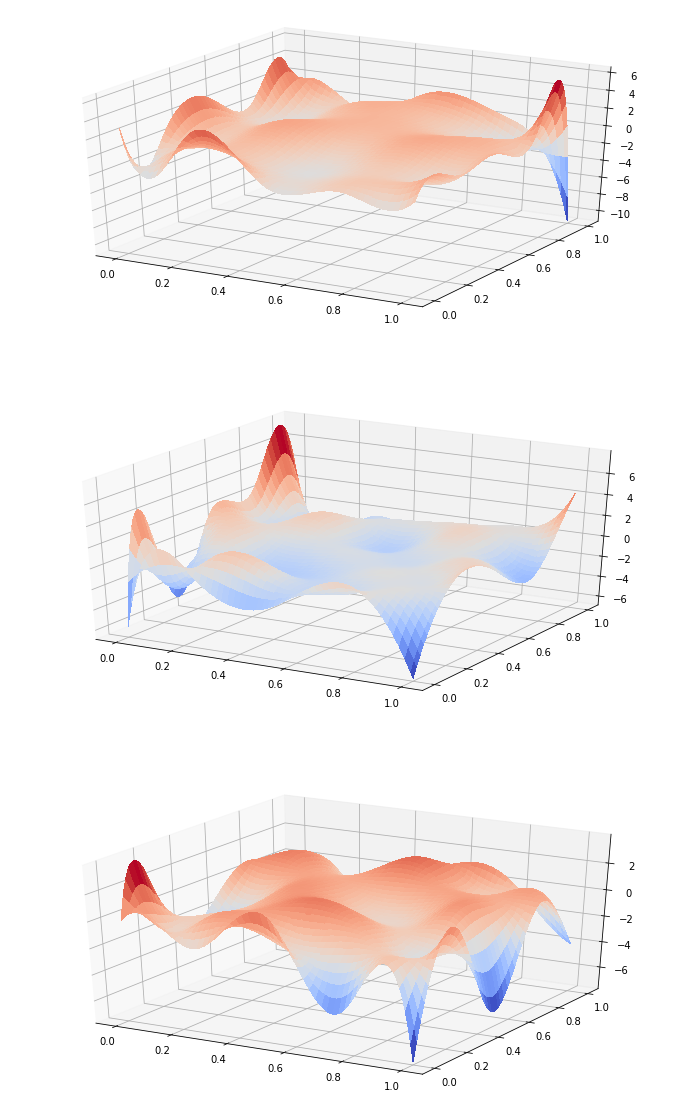

In [4]:
fig = plt.figure(figsize=(12, 20))

XX1, XX2 = np.meshgrid(xgrids[0], xgrids[1])

ax1 = fig.add_subplot(311,projection='3d')
surf1 = ax1.plot_surface(XX1, XX2, Psi_tensor[0,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax2 = fig.add_subplot(312,projection='3d')
surf2 = ax2.plot_surface(XX1, XX2, Psi_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax3 = fig.add_subplot(313,projection='3d')
surf3 = ax3.plot_surface(XX1, XX2, Psi_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [5]:
# Build random sample 
N = 100
#N = 20
Psi_coefs = np.random.multivariate_normal(np.zeros(m1*m2), np.diag(lambdas), size=N)
Y = np.zeros((n1,n2,N))
for i in range(N): 
    Y[:,:,i] = functools.reduce(operator.add,map(lambda k: Psi_coefs[i,k]*Psi_tensor[k,:,:], np.arange(m1*m2)))

In [7]:
nmode = 2
bspline_basis = [bsp1, bsp2] ## use true basis system for simplicity 
K = 30 ## rank of MPF basis  
## Compute basis evaluation matrices and SVDs
Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]
Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
## Specify differential operator for penalization 
D2 = LinearDifferentialOperator(2)
Rlst = [gramian_matrix(D2, bspline_basis[d]) for d in range(nmode)] 
## Perform the n-mode coordinate transformations into the spline coefficient space 
## Y_Bar should be close to zero so no need to center 
G = tl.tenalg.multi_mode_dot(Y, [svdt.U.T for svdt in Svds], list(range(nmode)))
## Estimation MPB
maxiter = (200, 100)
tol_inner = (1e-3, 1e-3)
tol_outer = 1e-3
initialize = "random"
Vs = [Svds[d].Vt.T for d in range(nmode)]
Dinvs = [np.diag(1./Svds[d].s) for d in range(nmode)]
Tlst_bcd = [Dinvs[d]@Vs[d].T@Rlst[d]@Vs[d]@Dinvs[d] for d in range(nmode)]
pen_params = (1e-10, 1e-10, 1e-10) ## no noise in simulation so regularization can be mild 
start = time.time()
Ctilde, Smat, scalars, FLAG_C, FLAG_N = MARGARITA(G, Tlst_bcd, pen_params, K, 
                                 max_iter=maxiter, tol_inner=tol_inner, 
                                 tol_outer=tol_outer,  regularization="l2", init=initialize, 
                                verbose=False)
elapsed = time.time() - start
Clst = [Svds[d].Vt.T @ np.diag(1/Svds[d].s) @ Ctilde[d] for d in range(nmode)] 
Smat_scaled = np.multiply(Smat, scalars)

In [8]:
Kprime = 3
mpb = MPB(bspline_basis, Clst)
## Perform FPCA 
J = mpb.gram_matrix()
R = mpb.roughness_matrix()
B, gamma = FPCA(Smat_scaled, J, R, lam=1e-10)

In [9]:
Zeta_tensor = np.zeros((K,n1,n2))
for k in range(K):
    Zeta_tensor[k,:,:] = (Phis[0] @ Clst[0][:,k]).reshape(-1,1) @ (Phis[1] @ Clst[1][:,k]).reshape(-1,1).T
Eta_tensor = tl.tenalg.mode_dot(Zeta_tensor, B.T, 0)

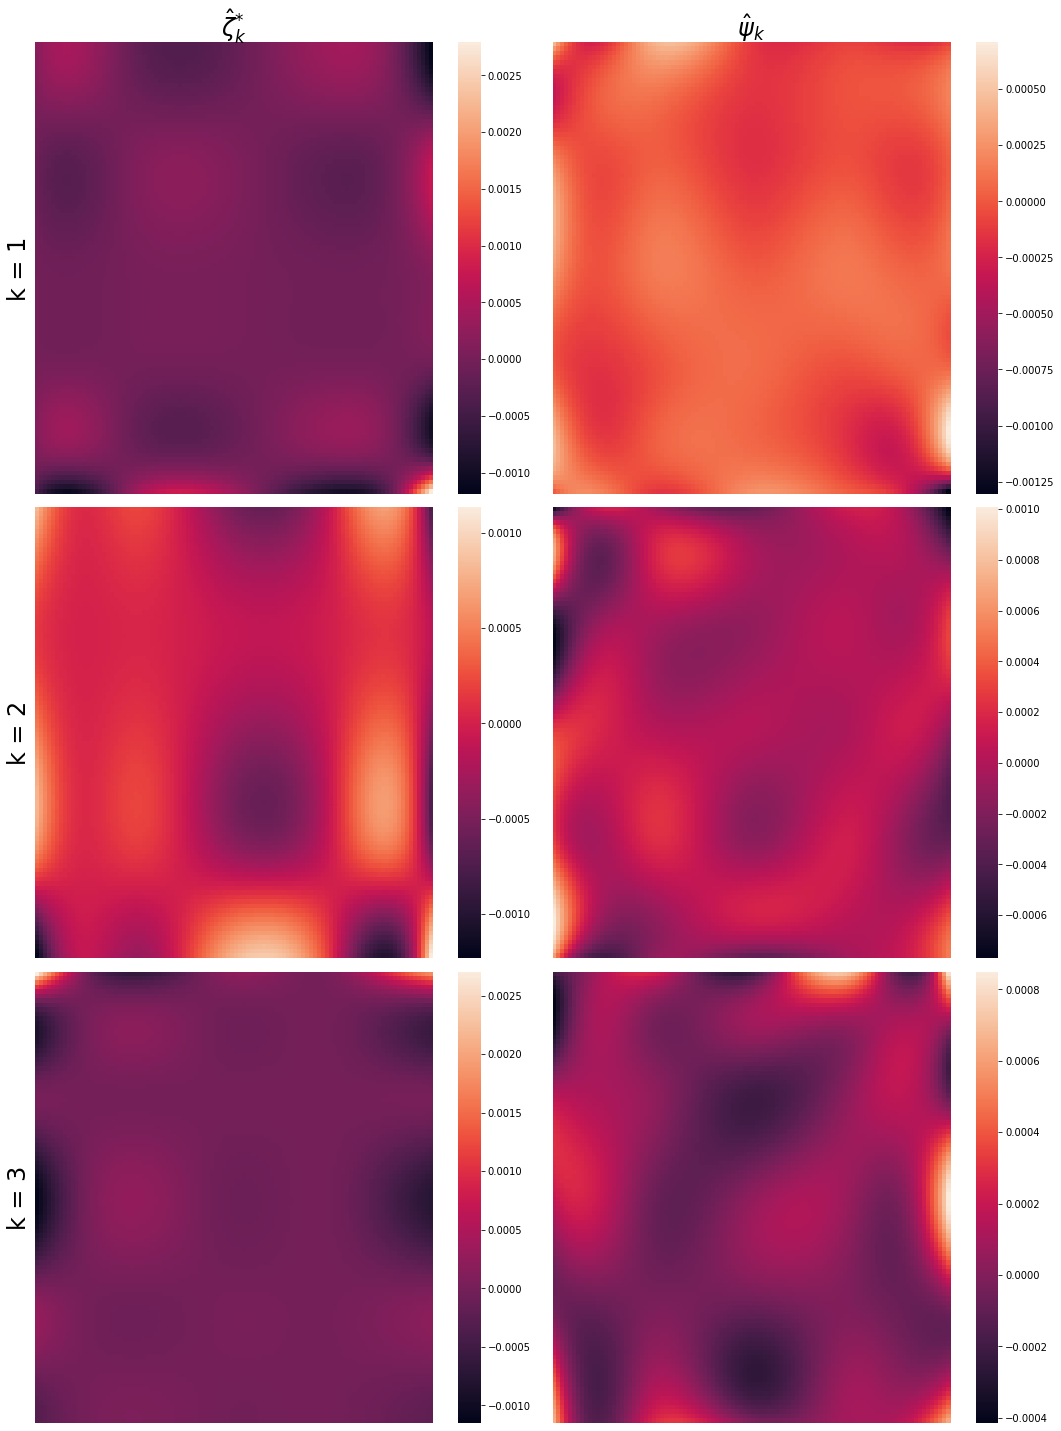

In [10]:
from sklearn.preprocessing import MinMaxScaler
f, ax = plt.subplots(3, 2, figsize=(15,20))

for k in range(3):
    
    ax_ = sns.heatmap(Zeta_tensor[k,:,:], ax=ax[k,0], xticklabels=False, yticklabels=False, rasterized=True)
    ax_.tick_params(left=False, bottom=False)
    ax_.set_ylabel(r'k = %s'%(k+1,),fontsize=24)
    
    ax_ = sns.heatmap(-Eta_tensor[k,:,:], ax=ax[k,1], xticklabels=False, yticklabels=False, rasterized=True)
    ax_.tick_params(left=False, bottom=False)
    
ax[0,0].set_title(r'$\hat{\zeta}^{*}_k$',fontsize=24)
ax[0,1].set_title(r'$\hat{\psi}_k$',fontsize=24)
    
f.tight_layout()

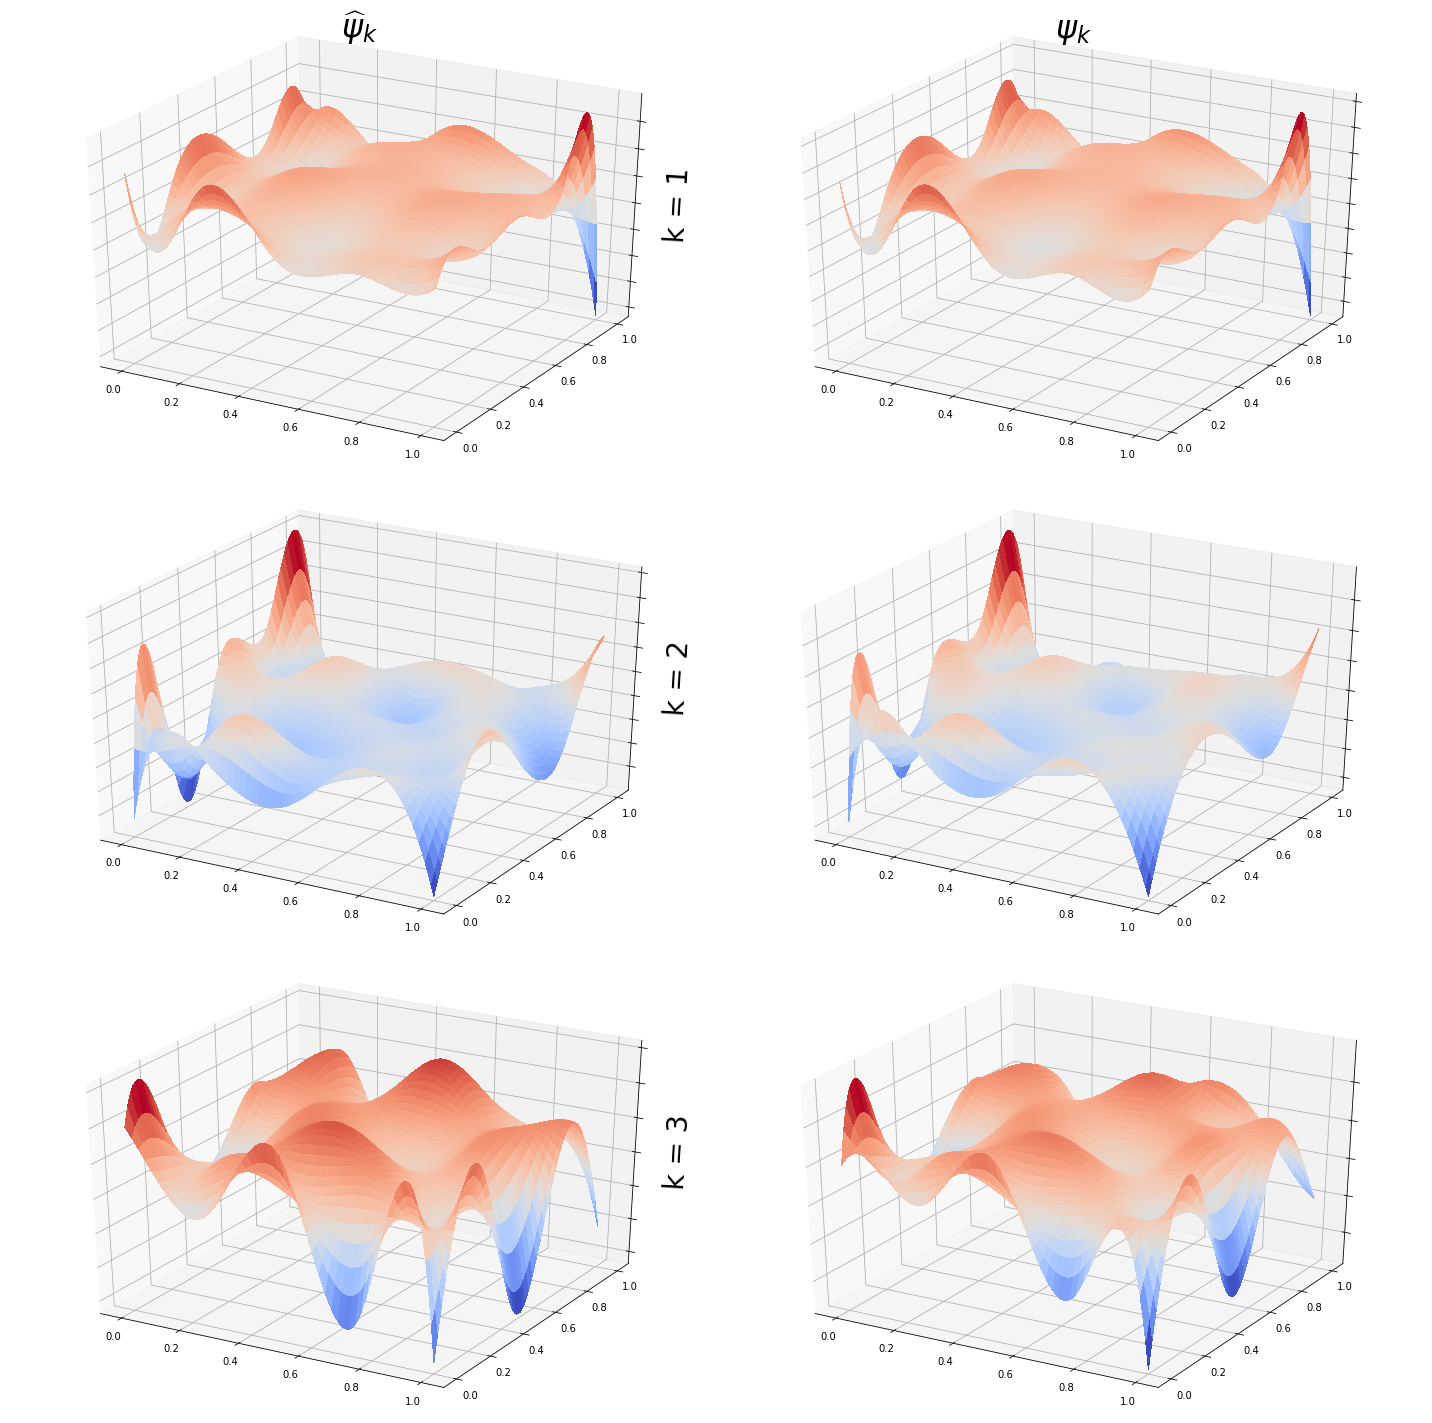

In [11]:
fig = plt.figure(figsize=(20, 20))

XX1, XX2 = np.meshgrid(xgrids[0], xgrids[1])

ax2 = fig.add_subplot(3,2,1,projection='3d')
surf2 = ax2.plot_surface(XX1, XX2, -Eta_tensor[0,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax2.zaxis.set_ticklabels([])
ax2.set_title(r'$\widehat{\psi}_k$', fontsize=32)
ax2.set_zlabel('k = 1', fontsize=28)

ax3 = fig.add_subplot(3,2,2,projection='3d')
surf3 = ax3.plot_surface(XX1, XX2, Psi_tensor[0,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3.zaxis.set_ticklabels([])
ax3.set_title(r'$\psi_k$',  fontsize=32)

ax5 = fig.add_subplot(3,2,3,projection='3d')
surf5 = ax5.plot_surface(XX1, XX2, -Eta_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax5.zaxis.set_ticklabels([])
ax5.set_zlabel('k = 2', fontsize=28)


ax6 = fig.add_subplot(3,2,4,projection='3d')
surf6 = ax6.plot_surface(XX1, XX2, Psi_tensor[1,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax6.zaxis.set_ticklabels([])

ax8 = fig.add_subplot(3,2,5,projection='3d')
surf8 = ax8.plot_surface(XX1, XX2, Eta_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax8.zaxis.set_ticklabels([])
ax8.set_zlabel('k = 3', fontsize=28)


ax9 = fig.add_subplot(3,2,6,projection='3d')
surf9 = ax9.plot_surface(XX1, XX2, Psi_tensor[2,:,:], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax9.zaxis.set_ticklabels([])

fig.tight_layout()

Note, due to sign unidentiabilitiy, manually changed in accordance w/ true eigenfunctions.